#Notebook: Model LSTM
##Author: Lucía Núñez Calvo
###Date: 22/04/2024

####Summary
This notebook shows two implementations of the Long Short-Term Memory (**LSTM**) model. The first implementation tests without cross-validation, while the second implementation tests using cross-validation.

In the first part of the notebook, the LSTM model is trained and evaluated **without** using **cross-validation** techniques. This allows the performance of the model to be observed on a single set of training and test data, providing an initial insight into its performance.

Subsequently, the second implementation is presented, where **cross-validation** is applied to evaluate the model. This technique splits the dataset into several parts and performs multiple training and evaluations. Cross-validation provides a more robust and reliable estimate of model performance by reducing the risk of overfitting and providing better generalisation over unseen data.

Each combination of these implementations (with and without cross-validation) has been realised using two types of audio analysis features: Mel Frequency Cepstral Coefficients (**MFCC**) and Linear Predictive Coding (**LPC**).

At the end of the notebook, a comparison of the results obtained from both implementations is performed. For this purpose, **confusion matrices** and graphs reflecting the **Accuracy**, **Recall** and **F1-score** metrics of the different classes have been created. These visualisations allow a detailed comparison of the performance of the model in each approach, providing a clear view of the strengths and weaknesses of each method and helping to determine the best strategy for classification.

----


####Structure of the notebook

0.   Load features
1.   LSTM without cross-validation
2.   LSTM with cross-validation
3.   Checking the results
4.   Save the results

In [4]:
import os
import librosa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### 1. Extract features

In [2]:
features_mfcc = np.load('features_mfcc.npy')
features_lpc = np.load('features_lpc.npy')
labels = np.load('labels.npy')

In [3]:
print("Length of MFCC features:", len(features_mfcc))
print("Length of LPC features:", len(features_lpc))
print("Length of labels:", len(labels))

Length of MFCC features: 432
Length of LPC features: 432
Length of labels: 432


## 1. LSTM without cross-validation

In [8]:
def create_model(features, labels):
  '''
  This function creates and trains an LSTM model.

  Input:
    - features: (array) Set of input features for the model.
    - labels: (array) Labels corresponding to the input features.

  Output:
    - model: (Sequential) Trained LSTM model.
    - y_test: (array) Labels of the test set.
    - y_pred: (array) Labels predicted by the model in the test set.
  '''
  # Division of data into training and test sets
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

  # Convert labels to one-hot format
  y_train = to_categorical(y_train, num_classes=4)
  y_test = to_categorical(y_test, num_classes=4)

  # Scaling the features
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # Definition of the LSTM model
  model = Sequential([
      LSTM(64, input_shape=(X_train_scaled.shape[1], 1), return_sequences=True),
      Dropout(0.5),
      LSTM(32, return_sequences=False),
      Dropout(0.3),
      Dense(4, activation='softmax')
  ])

  optimizer = Adam(learning_rate=0.001)  # Other tests with:  SGD(lr=0.01, momentum=0.9),  RMSprop(learning_rate=0.001)

  # Compile the model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  # Callbacks
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

  # Training the model
  model.fit(np.expand_dims(X_train_scaled, -1), y_train, epochs=100, batch_size=32,
              validation_data=(np.expand_dims(X_test_scaled, -1), y_test),
              callbacks=[early_stopping, reduce_lr], verbose=0)

  # Evaluation of the model
  predictions = model.predict(np.expand_dims(X_test_scaled, -1))
  y_pred = np.argmax(predictions, axis=1)
  y_test = np.argmax(y_test, axis=1)


  return model, y_test, y_pred

In [9]:
# Tests with MFCC features
model_mfcc, y_test_mfcc, y_pred_mfcc = create_model(features_mfcc, labels)


Epoch 41: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 51: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 66: early stopping
5/5 [==============================] - 1s 12ms/step


In [10]:
print(classification_report(y_test_mfcc, y_pred_mfcc))

              precision    recall  f1-score   support

           0       0.89      0.79      0.84        43
           1       1.00      1.00      1.00        30
           2       0.70      0.83      0.76        23
           3       0.97      1.00      0.99        34

    accuracy                           0.90       130
   macro avg       0.89      0.90      0.90       130
weighted avg       0.91      0.90      0.90       130



In [11]:
# Tests with LPC features
model_lpc, scaler_lpc, y_test_lpc, y_pred_lpc = create_model(features_lpc, labels)


Epoch 74: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 79: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 79: early stopping
5/5 [==============================] - 1s 6ms/step


In [12]:
print(classification_report(y_test_lpc, y_pred_lpc))

              precision    recall  f1-score   support

           0       0.83      0.93      0.88        43
           1       1.00      1.00      1.00        30
           2       0.83      0.65      0.73        23
           3       1.00      1.00      1.00        34

    accuracy                           0.92       130
   macro avg       0.92      0.90      0.90       130
weighted avg       0.92      0.92      0.91       130



In [3]:
def create_model_with_cross_validation(features, labels, num_classes=4):
    '''
    This function creates and trains an LSTM model.
    During each iteration of the cross-validation, the actual labels of the test set (y_test) and the labels predicted by the model (y_pred) are accumulated.
    This is done to combine the results of all the folds and get an overall evaluation of the model.

    Input:
      - features: (array) Set of input features for the model.
      - labels: (array) Labels corresponding to the input features.
      - num_classes: (int) Number of existing classes (default 4).

    Output:
      - pipeline: (Pipeline) Trained SVM model.
      - y_test: (array) Labels of the test set.
      - y_pred: (array) Labels predicted by the model in the test set.
    '''

    # Cross-validation with 5 folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y_test_accum = []
    y_pred_accum = []

    for train_index, test_index in cv.split(features, labels):

        # Division of data into training and test sets
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Convert labels to one-hot format
        y_train = to_categorical(y_train, num_classes=num_classes)
        y_test = to_categorical(y_test, num_classes=num_classes)

        # Scaling the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Definition of the LSTM model
        model = Sequential([
            LSTM(64, input_shape=(X_train_scaled.shape[1], 1), return_sequences=True),
            Dropout(0.5),
            LSTM(32, return_sequences=False),
            Dropout(0.3),
            Dense(num_classes, activation='softmax')
        ])

        # Optimizador y compilación
        optimizer = Adam(learning_rate=0.001)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

        # Training the model
        model.fit(np.expand_dims(X_train_scaled, -1), y_train, epochs=200, batch_size=32,
                  validation_data=(np.expand_dims(X_test_scaled, -1), y_test),
                  callbacks=[early_stopping, reduce_lr], verbose=0)

        # Evaluation of the model
        predictions = model.predict(np.expand_dims(X_test_scaled, -1))
        y_pred = np.argmax(predictions, axis=1)
        y_test = np.argmax(y_test, axis=1)

        # Accumulate results
        y_test_accum.extend(y_test)
        y_pred_accum.extend(y_pred)

    return model, np.array(y_test_accum), np.array(y_pred_accum)

In [19]:
# Tests with MFCC features and cross-validation
model_mfcc_cv, y_test_mfcc_cv, y_pred_mfcc_cv = create_model_with_cross_validation(features_mfcc, labels)


Epoch 26: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 31: early stopping
3/3 [==============================] - 1s 12ms/step

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 72: early stopping
3/3 [==============================] - 1s 12ms/step

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 54: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 59: early stopping
3/3 [==============================] - 1s 12ms/step

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 46: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 46: early stopping
3/3 [==============================] - 1s 12ms/step

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 31: ReduceLROnPlateau reducing learnin

In [20]:
print(classification_report(y_test_mfcc_cv, y_pred_mfcc_cv))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       108
           1       0.99      1.00      1.00       108
           2       0.81      0.80      0.80       108
           3       0.96      0.99      0.97       108

    accuracy                           0.90       432
   macro avg       0.89      0.90      0.89       432
weighted avg       0.89      0.90      0.89       432



In [15]:
# Tests with LPC features and cross-validation
model_lpc_cv, y_test_lpc_cv, y_pred_lpc_cv = create_model_with_cross_validation(features_lpc, labels)


Epoch 88: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 113: early stopping
3/3 [==============================] - 1s 6ms/step

Epoch 61: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 66: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 66: early stopping
3/3 [==============================] - 1s 8ms/step

Epoch 63: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 68: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 68: early stopping
3/3 [==============================] - 1s 7ms/step

Epoch 70: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 84: ReduceLROnPlateau reducing learning rate to 0.0001.
Epoch 100: early stopping
3/3 [==============================] - 1s 11ms/step

Epoch 90: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 102: ReduceLROnPlateau reducing learnin

In [16]:
print(classification_report(y_test_lpc_cv, y_pred_lpc_cv))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       108
           1       1.00      1.00      1.00       108
           2       0.89      0.70      0.79       108
           3       0.99      1.00      1.00       108

    accuracy                           0.91       432
   macro avg       0.91      0.91      0.90       432
weighted avg       0.91      0.91      0.90       432



## 3.   Checking the results

In [47]:
# Variables containing the labels the test and the labels predicted by the model in the test set
y_tests = [y_test_mfcc, y_test_mfcc_cv, y_test_lpc, y_test_lpc_cv]
y_preds = [y_pred_mfcc, y_pred_mfcc_cv, y_pred_lpc, y_pred_lpc_cv]

# Variable containing the titles for the representations
titles = ['Features extracted with MFCC and LSTM model', 'Features extracted with MFCC and LSTM model with cross-validation',
          'Features extracted with LPC and LSTM model', 'Features extracted with LPC and LSTM model with cross-validation']

In [ ]:
def display_confusion_matrices(y_tests, y_preds, titles):
    '''
    Function that displays confusion matrices for multiple models.

    Input:
      - y_tests: (list) List of arrays with the true values (y_test) of each model.
      - y_preds: (list) List of arrays with the predicted values (y_pred) of each model.
      - titles (list) List of titles for each subplot.
    '''
    num_models = len(y_tests)
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()

    for i in range(num_models):
        conf_matrix = confusion_matrix(y_tests[i], y_preds[i])
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=axes[i])
        axes[i].set_title(titles[i])
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

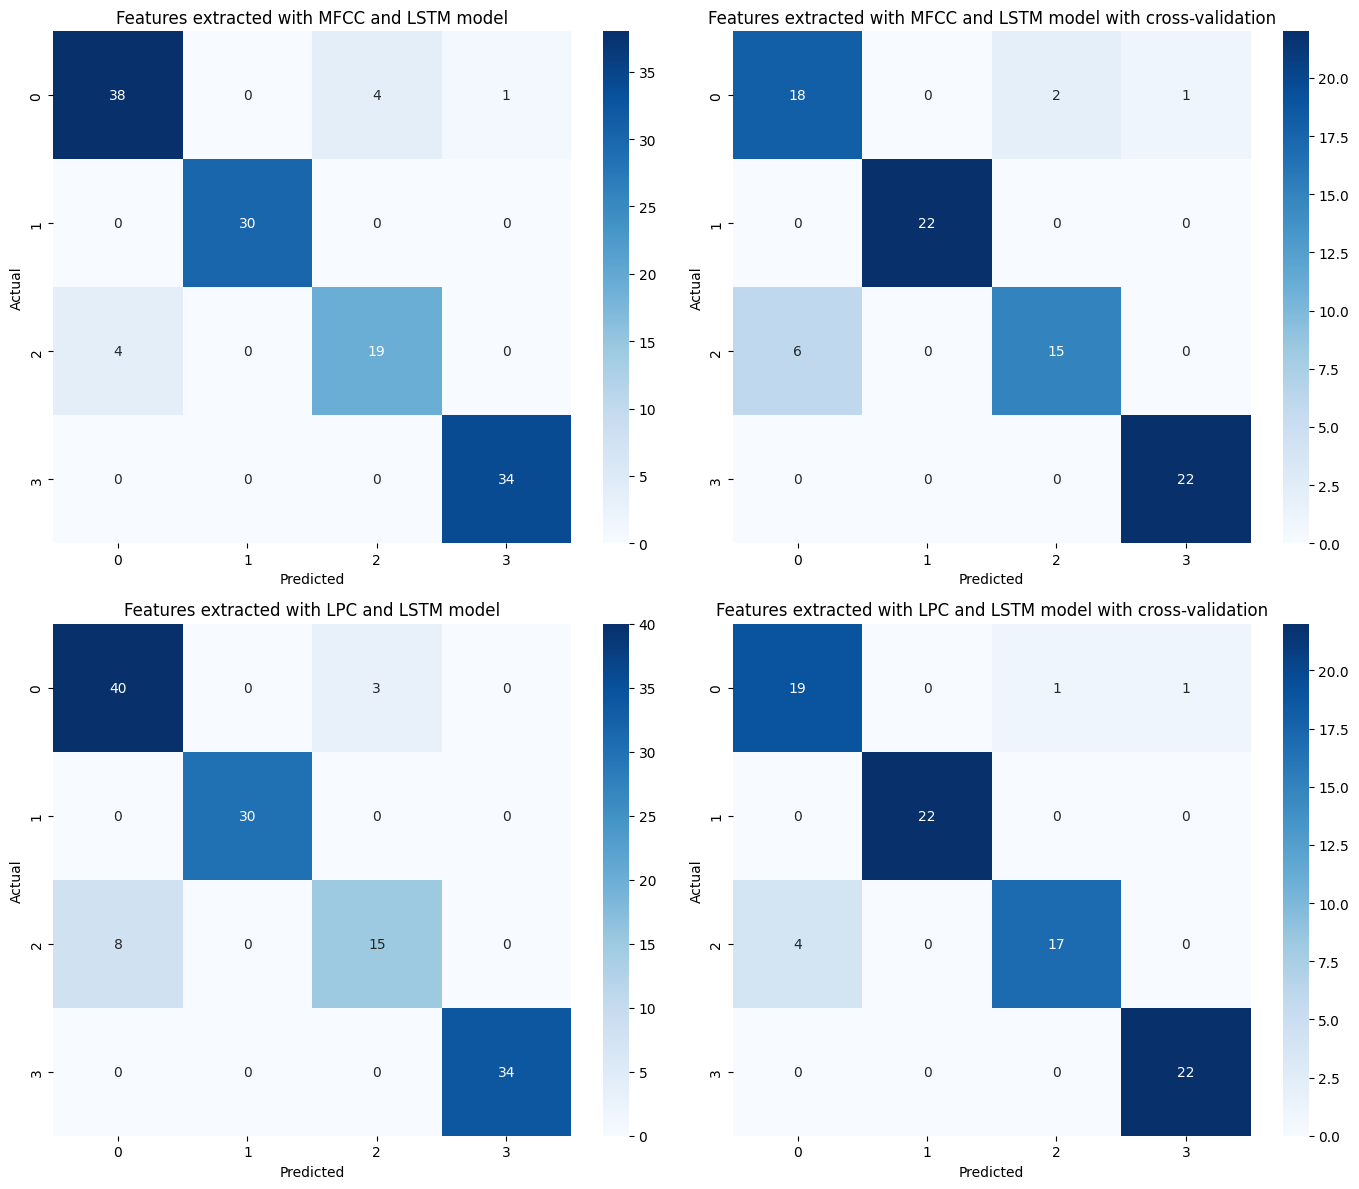

In [48]:
display_confusion_matrices(y_tests, y_preds, titles)

In [ ]:
def plot_classification_metrics_multiple(y_tests, y_preds, titles):
    '''
    Function that displays the ‘Precision’ ‘Recall’ and ‘F1-score’ for multiple models on a graph.

    Input:
      - y_tests: (list) List of arrays with the true values (y_test) of each model.
      - y_preds: (list) List of arrays with the predicted values (y_pred) of each model.
      - titles (list) List of titles for each subplot.
    '''

    num_models = len(y_tests)
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()

    for i in range(num_models):
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_tests[i], y_preds[i], average=None)
        x = np.arange(len(precision))  # Label locations
        width = 0.3  # Width of the bars

        axes[i].bar(x - width, precision, width, label='Precision', color='darkturquoise')
        axes[i].bar(x, recall, width, label='Recall', color='darksalmon')
        axes[i].bar(x + width, f1_score, width, label='F1 Score', color='darkseagreen')

        axes[i].set_ylabel('Scores')
        axes[i].set_title(titles[i])
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(['Class 0 - Crying baby', 'Class 1 - Silence', 'Class 2 - Noise', 'Class 3 - Baby laugh'])
        axes[i].legend()

        # Adding labels on the bars
        def autolabel(rects, ax):
            '''
            Function to add labels on the bars.
            '''
            for rect in rects:
                height = rect.get_height()
                ax.annotate('{}'.format(round(height, 2)),
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        rects1 = axes[i].bar(x - width, precision, width, color='darkturquoise')
        rects2 = axes[i].bar(x, recall, width, color='darksalmon')
        rects3 = axes[i].bar(x + width, f1_score, width, color='darkseagreen')

        autolabel(rects1, axes[i])
        autolabel(rects2, axes[i])
        autolabel(rects3, axes[i])

    fig.tight_layout()
    plt.show()

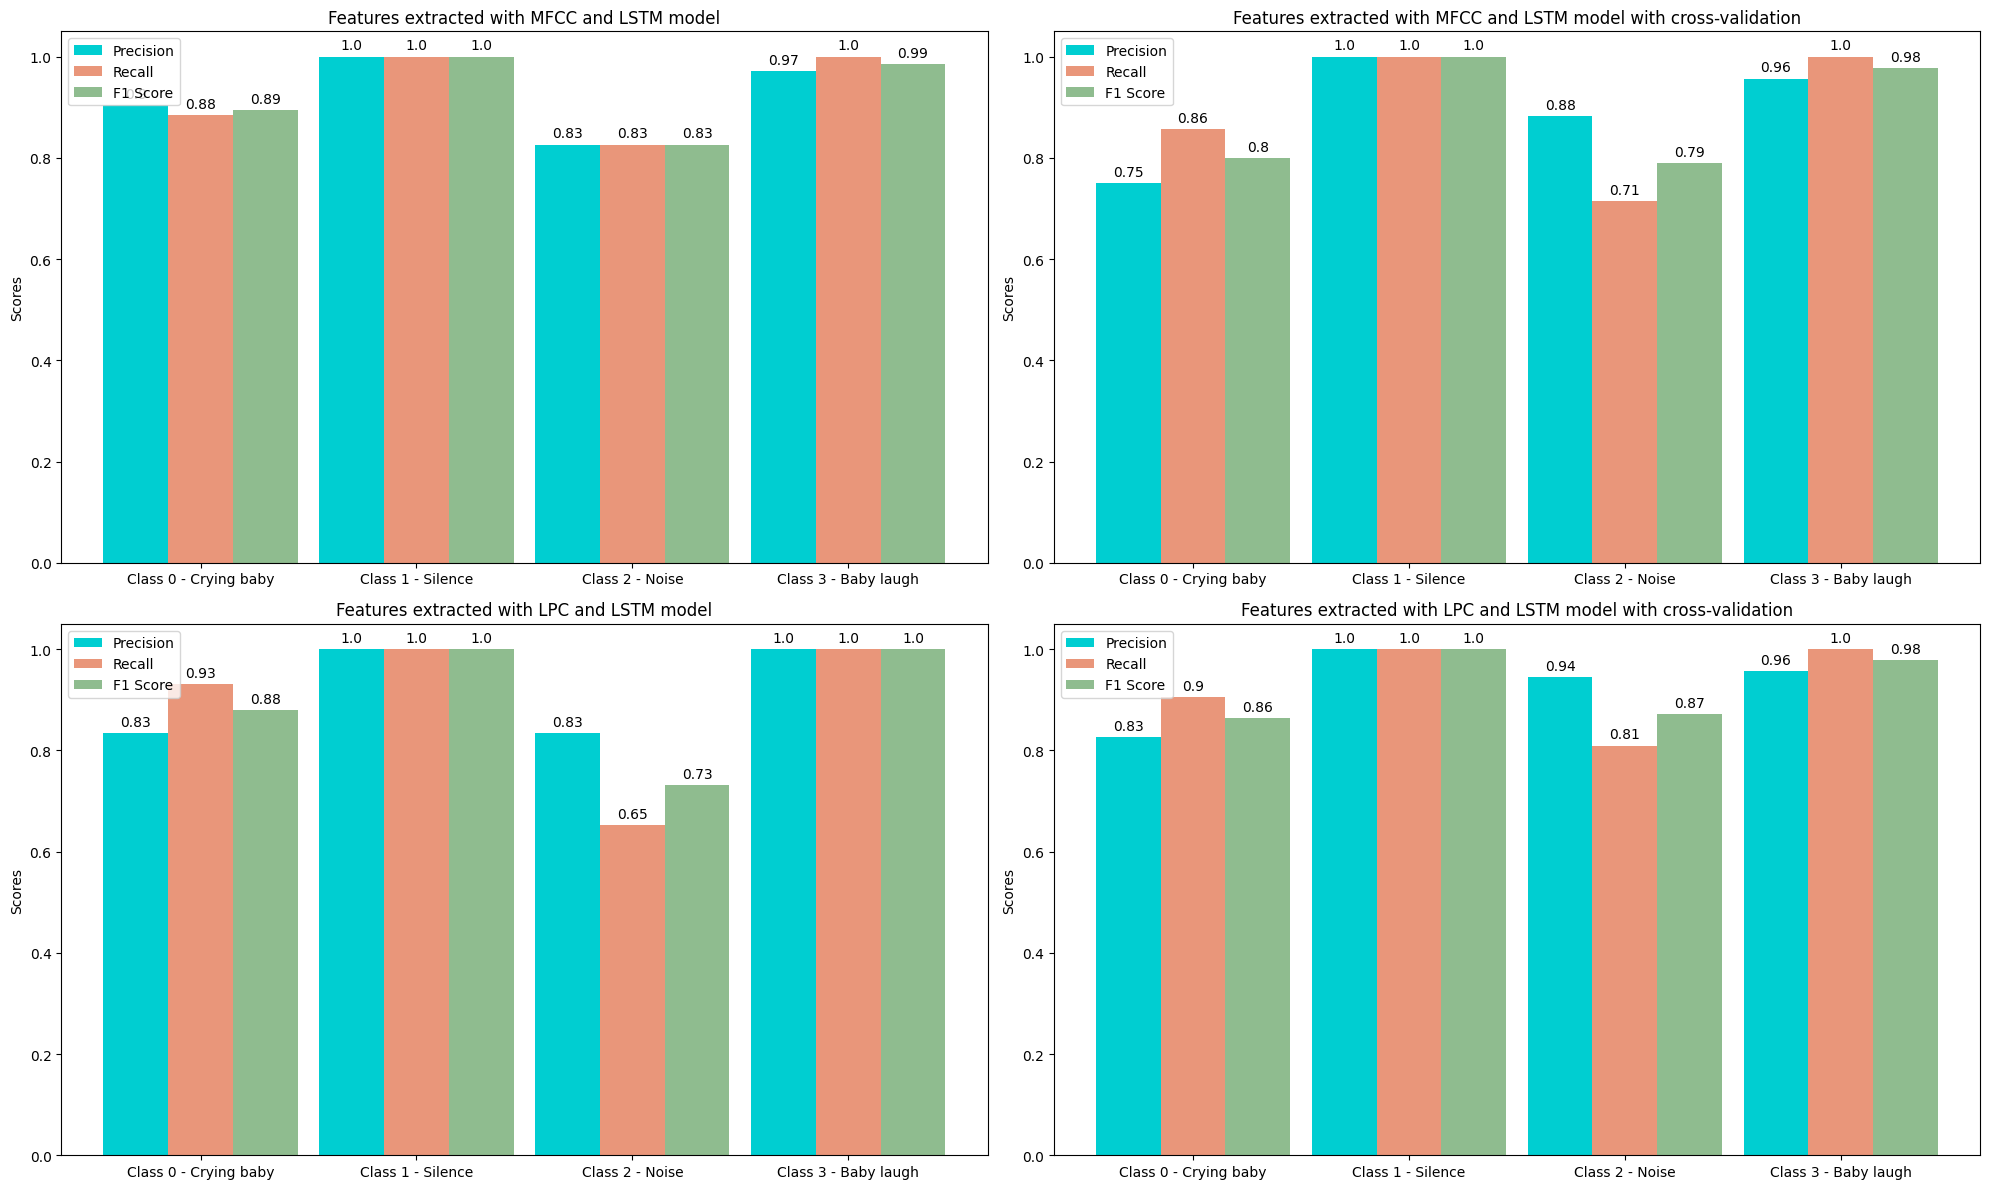

In [49]:
 plot_classification_metrics_multiple(y_tests, y_preds, titles)